# Simulate Enhanced TITAN framework (Han et al. 2009)
This notebook run the algorithm of ETitan (2009), including three stages:
1. **Identification:** use Morphological-based algorithm to identify storm cells.
2. **Tracking:**
    - Use overlapping of forecasting version to detect intermediately the absolute matches of storms.
    - Use Hungarian optimization to match: using differencei in volumes and centroid movement.
3. **Forecasting:** difference from the original TITAN, Enhanced TITAN use TREC directly from time frame $t-1$ to $t$ to estimate for the velocity (do not use linear interpolation)

*In some sense, tracking step is only used for estimate other parameters change: area (VIL and Top height are skipped in 2D simplication)*

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Total DBZ maps processed: 10. Shape of each DBZ map: (505, 1220)
----------------------------------------


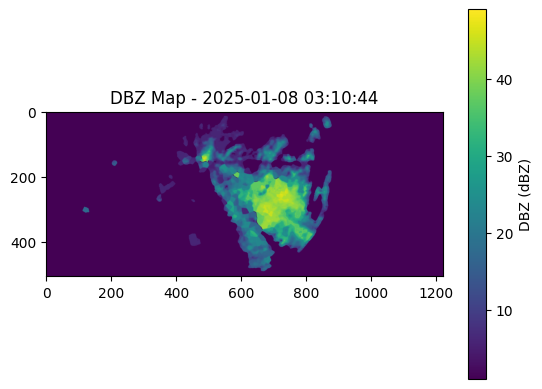

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

from src.utils import windy_preprocessing_pipeline, process_image

SOURCE_PATH = "data/images/philippines_13.269_123.832"
img_paths = [os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')][:50]

dbz_maps: list[tuple[np.ndarray, datetime]] = []

for img_path in tqdm(img_paths):
    img, time_frame = process_image(img_path)
    dbz_map = windy_preprocessing_pipeline(img)
    dbz_maps.append((dbz_map, time_frame))

print(f"Total DBZ maps processed: {len(dbz_maps)}. Shape of each DBZ map: {dbz_maps[0][0].shape}")
print("-"*40)

# Visualize first DBZ map
plt.imshow(dbz_maps[0][0], cmap='viridis')
plt.colorbar(label='DBZ (dBZ)')
plt.title(f"DBZ Map - {dbz_maps[0][1]}")
plt.show()

## Running

### 1. Identify storms

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


----------------------------------------


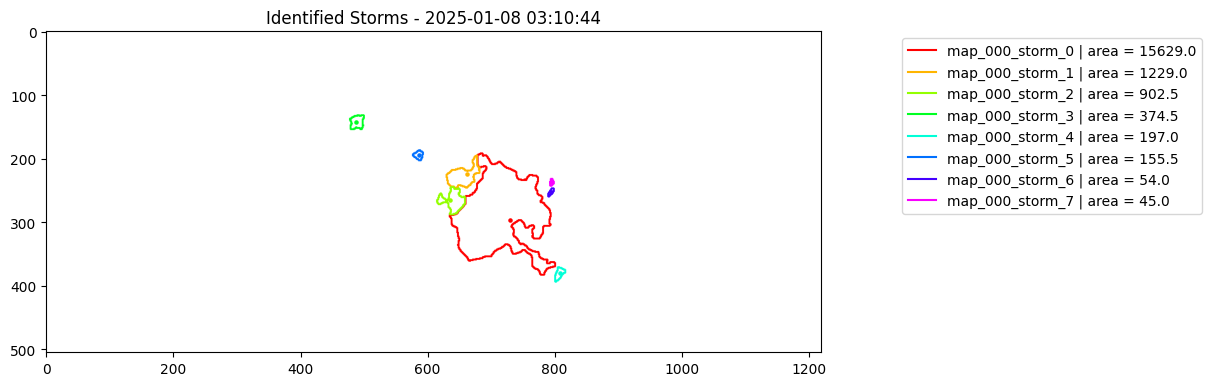

In [3]:
import cv2

from src.cores.base import StormsMap
from src.model.etitan_original import ETitanPrecipitationModel
from src.identification import MorphContourIdentifier
from src.utils import convert_polygons_to_contours

DBZ_THRESHOLD = 35  # dBZ
FILTER_AREA = 50  # pixels      ==> Less than 50 pixels will be filtered out

### Select identifier
# simple_identifier = SimpleContourIdentifier()
identifier = MorphContourIdentifier(n_thresh=3, center_filter=10)

model = ETitanPrecipitationModel(identifier=identifier)
storms_maps: list[StormsMap] = []

for idx, (dbz_map, time_frame) in tqdm(list(enumerate(dbz_maps))):
    storms_map = model.identify_storms(dbz_map, time_frame, map_id=f"map_{idx:03d}", threshold=DBZ_THRESHOLD, filter_area=FILTER_AREA)
    # storms_map = simple_identifier.identify_storm(dbz_map, threshold=DBZ_THRESHOLD, filter_area=FILTER_AREA)
    storms_maps.append(storms_map)

print("-"*40)

# Visualize storms with contours on the first DBZ map
storms_map = storms_maps[0]
plt.figure(figsize=(10, 8))

img_shape = dbz_maps[0][0].shape
img_shape = (img_shape[0], img_shape[1], 3)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

# colors = spectral_colors(len(storms_map.storms))

for storm in storms_map.storms:
    y_centroid, x_centroid = storm.centroid
    color = storm.contour_color
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=2)  # Draw contour in red

plt.imshow(blank_image, cmap='grey')
plt.title(f"Identified Storms - {storms_map.time_frame}")
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))

plt.show()

### 2. Field-map illustration

10


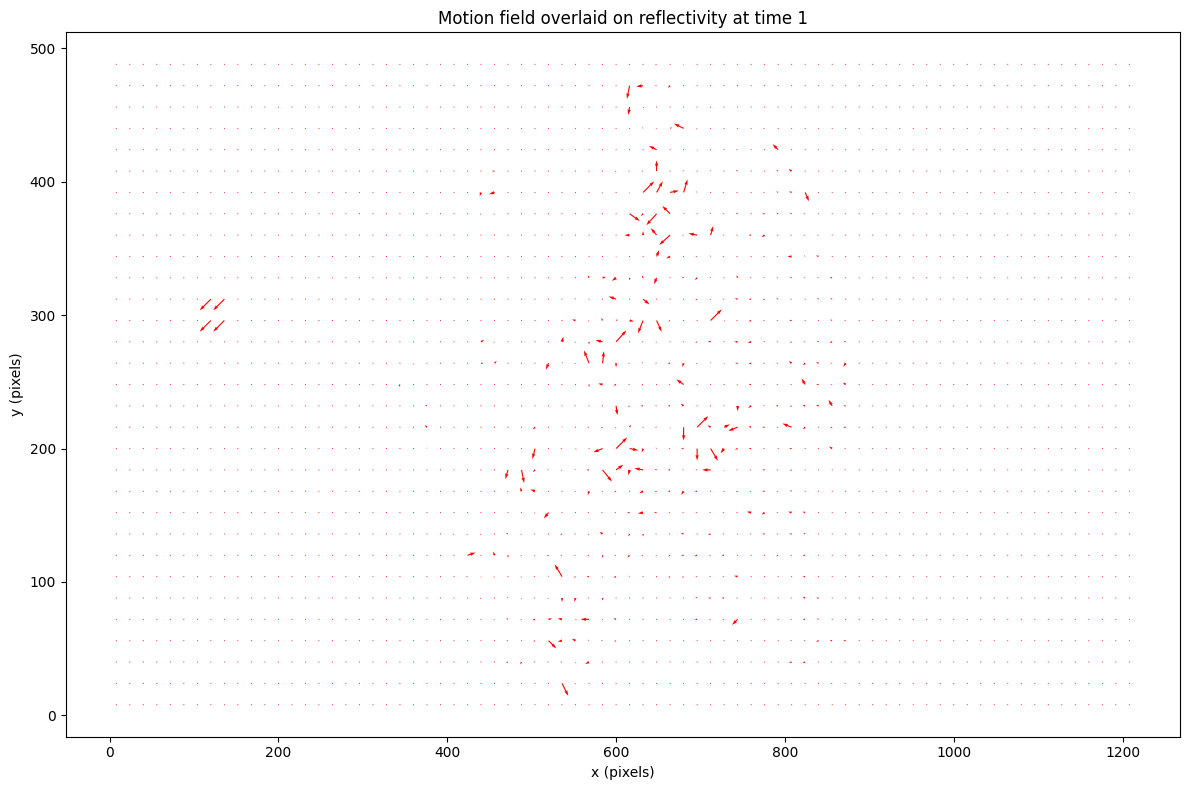

In [8]:
from src.cores.movement_estimate import estimate_trec_by_blocks

prev_storms_map = storms_maps[0]
curr_storms_map = storms_maps[1]
dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # in hours
local_buffer = int(100 * dt)

print(local_buffer)

grid_y, grid_x, vy, vx = estimate_trec_by_blocks(prev_storms_map, curr_storms_map, block_size=16, stride=16)

plt.figure(figsize=(12, 8))

# Plot motion vectors
plt.quiver(
    grid_x, grid_y,        # vector positions (centers of blocks)
    vx, vy,                # vector components (dx, dy)
    # angles="xy", 
    scale_units="xy", 
    scale=1,
    color="red", 
    width=0.001
)

plt.title(f"Motion field overlaid on reflectivity at time {1}")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
# plt.xlim(400, 600)
# plt.ylim(100, 300)

plt.tight_layout()
plt.show()

### 2.2 Visualization matching and derived motion

Centroid: x=725, y=301
Storm map_001_storm_0 movement: dy=-0.21, dx=-1.13 pixels


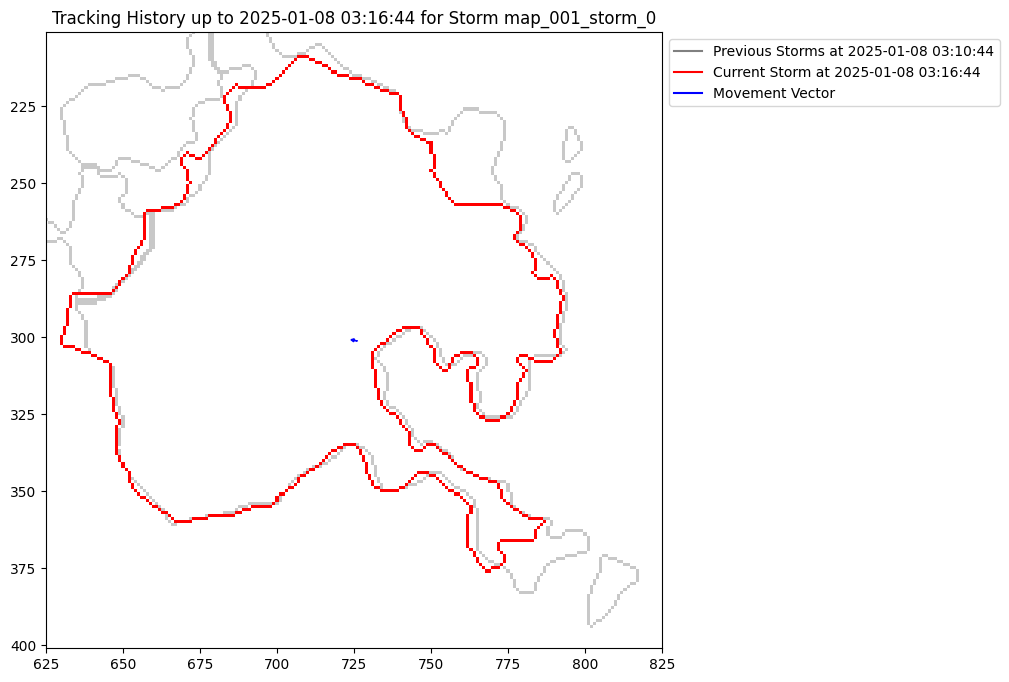

In [ ]:
import cv2

identifier = MorphContourIdentifier(n_thresh=3, center_filter=10)
model = ETitanPrecipitationModel(identifier=identifier)

train_len = 2
for i in range(train_len):
    model.processing_map(storms_maps[i])

plt.figure(figsize=(10, 8))
img_shape = dbz_maps[0][0].shape
img_shape = (img_shape[0], img_shape[1], 3)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

## plot previous storms map
prev_storms_map = model.storms_maps[-2]
for storm in prev_storms_map.storms:
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, (200, 200, 200), thickness=1)  # Draw contour in gray

plt.plot([], [], color='gray', label=f"Previous Storms at {prev_storms_map.time_frame}")

# plot current storm + movement history
curr_idx = 0
curr_storms_map = model.storms_maps[-1]
curr_storm = curr_storms_map.storms[curr_idx]

dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hour

centroid_y, centroid_x = curr_storm.centroid
print(f"Centroid: x={centroid_x}, y={centroid_y}")
cv2.drawContours(blank_image, convert_polygons_to_contours([curr_storm.contour]), -1, (255, 0, 0), thickness=1)  # Draw

plt.plot([], [], color='red', label=f"Current Storm at {curr_storms_map.time_frame}")

# plot movement vector
movement = curr_storm.get_movement()
if movement is None:
    dy, dx = 0.0, 0.0
else:
    dy, dx = movement * dt

print(f"Storm {curr_storm.id} movement: dy={dy:.2f}, dx={dx:.2f} pixels")
plt.arrow(centroid_x-dx, centroid_y-dy, dx, dy, color='blue', head_width=1, head_length=1)
plt.plot([], [], color='blue', label=f"Movement Vector")

plt.xlim(centroid_x - 100, centroid_x + 100)
plt.ylim(centroid_y + 100, centroid_y - 100)
plt.imshow(blank_image, cmap='grey')
plt.title(f"Tracking History up to {curr_storms_map.time_frame} for Storm {curr_storm.id}")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### 2.3 Run to compute POD, FAR, CSI

In [15]:
from src.cores.base import StormsMap
from src.cores.metrics import pod_score, far_score, csi_score
import warnings

warnings.filterwarnings("ignore")

class PredictionBenchmarkModel:
    def __init__(self):
        self.pods = []
        self.fars = []
        self.csis = []
        self.actual = []
        self.predicted = []

    def evaluate_predict(self, actual_storms_map: StormsMap, predicted_storms_map: StormsMap):
        self.actual.append(actual_storms_map)
        self.predicted.append(predicted_storms_map)
        self.pods.append(pod_score(actual_storms_map, predicted_storms_map))
        self.fars.append(far_score(actual_storms_map, predicted_storms_map))
        self.csis.append(csi_score(actual_storms_map, predicted_storms_map))

PREDICT_FORWARD_STEPS = 3                           # 1 hour ahead
SLOW_START_STEPS = 10

model = ETitanPrecipitationModel(identifier=MorphContourIdentifier(n_thresh=3, center_filter=10))
temp_storm_map = storms_maps

ours_model_evaluation = PredictionBenchmarkModel()
predicted_maps = []

for i in tqdm(range(SLOW_START_STEPS), desc="Warming up the model"):
    model.processing_map(temp_storm_map[i])  # Warm-up phase

lead_times = []

for curr_map, future_map in tqdm(list(zip(temp_storm_map[SLOW_START_STEPS:], temp_storm_map[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
    # Predict map using current data
    dt = (future_map.time_frame - model.storms_maps[-1].time_frame).total_seconds() / 3600  # in hours
    predicted_map = model.forecast(dt)
    ours_model_evaluation.evaluate_predict(future_map, predicted_map)
    lead_times.append(dt * 60)  # Convert hours to minutes

    # Update new map into knowledge
    model.processing_map(curr_map)  # Update model with the current map

print("Our model evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")
print(f"\tAverage Lead time (minutes): {np.mean(lead_times):.2f}")

Predicting precipitation maps: 100%|██████████| 37/37 [00:04<00:00,  7.89it/s]

Our model evaluation:
	Average POD: 0.4998
	Average FAR: 0.5136
	Average CSI: 0.3329
	Average Lead time (minutes): 24.02
